### 🛠️ Step 0: 初期設定と環境準備（val_lossモード切替対応）

このステップでは、複合モデルでの学習に必要な共通設定を初期化します。  
`val_losses.json` をもとにロス関数の重みを決定するため、  
モード切り替え（"latest" or "average"）にも対応できるように設計されています。

#### 💡 含まれる設定内容：

- `TARGET_COLS` の定義
- ハイパーパラメータ（画像サイズ・学習率など）
- `val_loss_mode` による重み決定のモード切替（"latest" / "average"）
- loss_weights を生成する関数（逆数＋正規化処理付き）

In [2]:
# === ライブラリ読み込み ===
import torch
from pathlib import Path
import json

# === 対象パラメータ（順番が重要！）===
TARGET_COLS = ["dipCount", "hue_cos", "hue_sin", "circleCount"]

# === ハイパーパラメータ設定 ===
IMAGE_SIZE = 128
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

# === パス設定 ===
VAL_LOSS_PATH = Path("../../loss_stats/val_losses.json")

# === デバイス設定（Mac対応） ===
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"✅ Using device: {device}")

# === 重み生成モードの切替（"latest" or "average"）===
VAL_LOSS_MODE = "average"  # ← "latest" でもOK

# === val_losses.json の読み込み ===
if not VAL_LOSS_PATH.exists():
    raise FileNotFoundError(f"{VAL_LOSS_PATH} が見つかりません。先に単体学習を実行してください。")

with open(VAL_LOSS_PATH, "r") as f:
    raw = json.load(f)

# === 重み決定処理 ===
if VAL_LOSS_MODE == "latest":
    val_losses = raw
elif VAL_LOSS_MODE == "average":
    val_losses = {k: sum(v) / len(v) for k, v in raw.items()}
else:
    raise ValueError(f"Unknown VAL_LOSS_MODE: {VAL_LOSS_MODE}")

# === 重みを逆数化・最大値正規化して list に変換 ===
inv = {k: 1.0 / v for k, v in val_losses.items()}
max_val = max(inv.values())
loss_weights = [inv[k] / max_val for k in TARGET_COLS]

print("📐 重み（loss_weights）:", loss_weights)

✅ Using device: mps
📐 重み（loss_weights）: [0.005742417598103494, 1.0, 0.44900474659074535, 5.3580972622666175e-08]


### 📄 Step 1: metadata.csv の読み込みと正規化

このステップでは、元データである `metadata.csv` を読み込み、  
画像ファイルの存在チェックを行った上で、  
`TARGET_COLS` に対する各パラメータを **Z-score正規化** します。  
また、後で逆正規化にも使えるよう、平均と標準偏差を `normalization_params.json` に保存します。

#### 💡 含まれる処理：

- CSV読み込み＋画像パスの作成
- 画像ファイルが存在するサンプルに限定
- 各パラメータの Z-score 正規化（平均0, 分散1）
- 正規化パラメータの保存

In [3]:
import pandas as pd
import numpy as np

# === データ読み込みパス ===
DATA_DIR = Path("../../data/circle-stroke")
CSV_PATH = DATA_DIR / "metadata.csv"
IMG_DIR = DATA_DIR / "images"
NORMALIZATION_PATH = DATA_DIR / "normalization_params.json"

# === CSV読み込み ===
df = pd.read_csv(CSV_PATH)
df_targets = df[["id"] + ["dipCount", "hue", "circleCount"]].copy()

# === 画像ファイルの存在チェック ===
df_targets["filename"] = df_targets["id"].apply(lambda x: f"image_{x}.png")
df_targets["filepath"] = df_targets["filename"].apply(lambda x: IMG_DIR / x)
df_targets = df_targets[df_targets["filepath"].apply(lambda x: x.exists())].reset_index(drop=True)

# === 正規化パラメータの計算と適用 ===
normalization_params = {}
for col in ["dipCount", "circleCount"]:
    mean = df_targets[col].mean()
    std = df_targets[col].std()
    df_targets[col] = (df_targets[col] - mean) / std
    normalization_params[col] = {"mean": mean, "std": std}

# === 保存（JSON形式）===
with open(NORMALIZATION_PATH, "w") as f:
    json.dump(normalization_params, f, indent=2)

print("✅ 正規化パラメータを保存しました:", NORMALIZATION_PATH)
print("✅ 対象サンプル数:", len(df_targets))

✅ 正規化パラメータを保存しました: ../../data/circle-stroke/normalization_params.json
✅ 対象サンプル数: 999


### 🧾 Step 2: Dataset クラスの定義（cos/sin変換対応）

このステップでは、画像と複数のパラメータをセットで返す PyTorch Dataset を構築します。  
`hue` は周期性に対応するため `(cos, sin)` に変換し、  
それ以外のパラメータ（`dipCount`, `circleCount`）は **Step 1で正規化済み** の値をそのまま使用します。

#### 💡 含まれる処理：

- 入力画像の読み込みとResize / Tensor変換
- `hue` → `cos`, `sin` に変換（deg→rad→三角関数）
- 複数パラメータを `torch.tensor([a, b, c, d])` で返す

In [4]:
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import torch
import numpy as np

class MultiParamDataset(Dataset):
    def __init__(self, df, image_size=128):
        self.df = df.reset_index(drop=True)
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # 画像読み込み
        image = Image.open(row["filepath"]).convert("RGB")
        image = self.transform(image)

        # ラベル構築
        dip = row["dipCount"]           # 正規化済み
        hue_deg = row["hue"]            # 角度 [0, 360)
        circle = row["circleCount"]     # 正規化済み

        hue_rad = np.deg2rad(hue_deg)
        hue_cos, hue_sin = np.cos(hue_rad), np.sin(hue_rad)

        label = torch.tensor([dip, hue_cos, hue_sin, circle], dtype=torch.float32)

        return image, label

### 📦 Step 3: train/val 分割と DataLoader の構築

このステップでは、前ステップで構築した `df_targets` を 80:20 に分割し、  
`MultiParamDataset` を使用して PyTorch DataLoader を作成します。  
shuffleの有無によって訓練と検証用で動作が異なるように設定します。

#### 💡 含まれる処理：

- `train_test_split`（scikit-learn）で分割
- `DataLoader` をバッチサイズ・シャッフル設定付きで作成

In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# === データ分割 ===
df_train, df_val = train_test_split(df_targets, test_size=0.2, random_state=42)

# === Dataset インスタンス化 ===
train_dataset = MultiParamDataset(df_train, image_size=IMAGE_SIZE)
val_dataset = MultiParamDataset(df_val, image_size=IMAGE_SIZE)

# === DataLoader 作成 ===
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ train: {len(train_dataset)}件, val: {len(val_dataset)}件")

✅ train: 799件, val: 200件


### 🧠 Step 4: CNNモデルの定義（出力4次元）

このステップでは、画像から `[dipCount, hue_cos, hue_sin, circleCount]` の4つを同時に回帰する  
CNNモデル `MultiParamCNN` を定義します。構造はシンプルな2層Conv + FCで、  
出力層のユニット数を4にすることで、複数パラメータ回帰に対応させます。

#### 💡 含まれる内容：

- 入力：RGB画像（3×128×128）
- 出力：4次元ベクトル（float）→ [dip, cos, sin, circle]
- 出力層のノード数 = `len(TARGET_COLS)`

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class MultiParamCNN(nn.Module):
    def __init__(self, image_size=128, output_dim=4):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        flatten_size = 32 * (image_size // 4) * (image_size // 4)
        self.fc1 = nn.Linear(flatten_size, 64)
        self.fc2 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)  # shape: (B, 4)

### 🏋️‍♂️ Step 5: 学習ループ（WeightedMSELoss + wandb対応）

このステップでは、重み付き損失関数 `WeightedMSELoss` を使って  
複数パラメータを同時に学習する学習ループを構築します。  
また、各エポックごとの `train_loss` / `val_loss` を wandb にログ記録します。

#### 💡 含まれる構成：

- `WeightedMSELoss` クラスの定義と `loss_weights` の注入
- `model`, `criterion`, `optimizer` の準備
- エポック単位で train/val のロスを記録
- wandb ログ付き

In [7]:
import wandb
from tqdm import tqdm

# === 損失関数定義 ===
class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.weights = torch.tensor(weights).float()

    def forward(self, pred, target):
        return ((self.weights.to(pred.device) * (pred - target) ** 2).mean())

# === wandb 初期化 ===
wandb.init(
    project="parametric-visual-learning",
    name="image2params_v3",
    config={
        "epochs": NUM_EPOCHS,
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "image_size": IMAGE_SIZE,
        "loss_weights": loss_weights,
        "val_loss_mode": VAL_LOSS_MODE
    }
)

# === モデル準備 ===
model = MultiParamCNN(image_size=IMAGE_SIZE, output_dim=len(TARGET_COLS)).to(device)
criterion = WeightedMSELoss(loss_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
val_losses = []

# === 学習ループ ===
for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * images.size(0)
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # === 検証ループ ===
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item() * images.size(0)

    avg_val_loss = total_val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)

    # === ログ記録 ===
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss
    })

    print(f"[{epoch+1}] 🟢 Train Loss: {avg_train_loss:.4f} | 🔵 Val Loss: {avg_val_loss:.4f}")

wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kimurakoya (ritsumeikan-math). Use `wandb login --relogin` to force relogin


Epoch 1/10: 100%|██████████| 25/25 [00:22<00:00,  1.12it/s, loss=0.00449]


[1] 🟢 Train Loss: 0.0541 | 🔵 Val Loss: 0.0089


Epoch 2/10: 100%|██████████| 25/25 [00:20<00:00,  1.22it/s, loss=0.00401]


[2] 🟢 Train Loss: 0.0056 | 🔵 Val Loss: 0.0047


Epoch 3/10: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s, loss=0.00379]


[3] 🟢 Train Loss: 0.0036 | 🔵 Val Loss: 0.0042


Epoch 4/10: 100%|██████████| 25/25 [00:19<00:00,  1.25it/s, loss=0.00272]


[4] 🟢 Train Loss: 0.0030 | 🔵 Val Loss: 0.0036


Epoch 5/10: 100%|██████████| 25/25 [00:24<00:00,  1.03it/s, loss=0.00216]


[5] 🟢 Train Loss: 0.0025 | 🔵 Val Loss: 0.0028


Epoch 6/10: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s, loss=0.00216]


[6] 🟢 Train Loss: 0.0022 | 🔵 Val Loss: 0.0023


Epoch 7/10: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s, loss=0.0015] 


[7] 🟢 Train Loss: 0.0018 | 🔵 Val Loss: 0.0022


Epoch 8/10: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s, loss=0.00135]


[8] 🟢 Train Loss: 0.0017 | 🔵 Val Loss: 0.0022


Epoch 9/10: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s, loss=0.00206]


[9] 🟢 Train Loss: 0.0016 | 🔵 Val Loss: 0.0023


Epoch 10/10: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s, loss=0.00172] 


[10] 🟢 Train Loss: 0.0015 | 🔵 Val Loss: 0.0020


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▂▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▁▁▁▁▁
epoch,10
train_loss,0.00147
val_loss,0.00196


### 🔍 Step 6: 推論 + 逆正規化 + 可視化

このステップでは、valデータの中から一部を取り出し、モデルによる予測結果を表示します。  
`dipCount` / `circleCount` は正規化を逆変換、`hue` は `(cos, sin)` → `arctan2` → 度数に戻します。  
結果は画像上に **予測と真値の数値（角度含む）** を並べて表示します。

#### 💡 含まれる処理：

- `normalization_params.json` の読み込みと逆変換
- `hue_cos`, `hue_sin` から `deg(arctan2(...))` による角度復元
- matplotlibで画像＋テキスト付きで可視化（8枚表示）

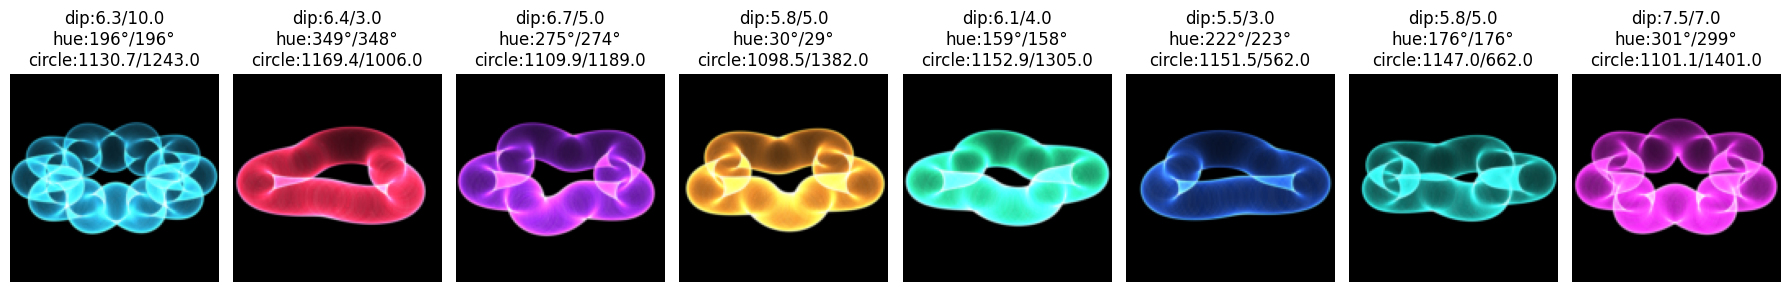

In [9]:
import matplotlib.pyplot as plt

# === 正規化パラメータの読み込み ===
with open(NORMALIZATION_PATH, "r") as f:
    norm_params = json.load(f)

# === 推論モードへ ===
model.eval()
num_samples = 8
plt.figure(figsize=(18, 4))

for i in range(num_samples):
    image, label = val_dataset[i]
    with torch.no_grad():
        pred = model(image.unsqueeze(0).to(device)).squeeze().cpu()

    # ラベルと予測を分解
    dip_gt, hue_cos_gt, hue_sin_gt, circle_gt = label.tolist()
    dip_pred, hue_cos_pred, hue_sin_pred, circle_pred = pred.tolist()

    # 逆正規化（dip / circle）
    dip_gt = dip_gt * norm_params["dipCount"]["std"] + norm_params["dipCount"]["mean"]
    dip_pred = dip_pred * norm_params["dipCount"]["std"] + norm_params["dipCount"]["mean"]
    circle_gt = circle_gt * norm_params["circleCount"]["std"] + norm_params["circleCount"]["mean"]
    circle_pred = circle_pred * norm_params["circleCount"]["std"] + norm_params["circleCount"]["mean"]

    # hue: cos/sin → 角度へ逆変換
    hue_gt = np.rad2deg(np.arctan2(hue_sin_gt, hue_cos_gt)) % 360
    hue_pred = np.rad2deg(np.arctan2(hue_sin_pred, hue_cos_pred)) % 360

    # 可視化
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"dip:{dip_pred:.1f}/{dip_gt:.1f}\n"
              f"hue:{hue_pred:.0f}°/{hue_gt:.0f}°\n"
              f"circle:{circle_pred:.1f}/{circle_gt:.1f}")
    plt.axis("off")

plt.tight_layout()
plt.show()

### 📉 Step 7: Lossカーブの描画（train / val）

このステップでは、各エポックで記録した `train_loss` と `val_loss` を  
折れ線グラフで表示し、学習の進み具合を視覚的に確認します。

#### 💡 含まれる処理：

- matplotlib による折れ線グラフ描画
- 学習の収束傾向・過学習の兆候を視覚化

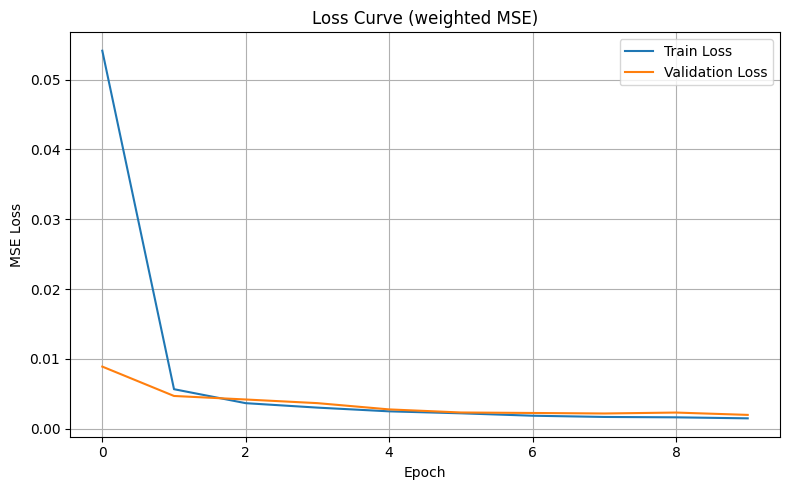

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Loss Curve (weighted MSE)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()